#Environment configuration

Import packages.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import numpy as np
import os
import math
import argparse
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import shutil

from google.colab import drive
from tabulate import tabulate
import time

os.system('pip install alive-progress -q')
from alive_progress import alive_bar

Set up directories and device.

In [ ]:
drive.mount('/content/drive')
gdrive = '/content/drive/My Drive/ml_projects/STRHANGE/'
keypoints_path = gdrive + '/data/JESTER/extracted/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set up functions and classes

This section contains all functions and classes that are important for the remainder of this notebook. An explanation of the functions and their parameters & outputs can be found in the function headers.

In [ ]:
def run_task(X, y, num_classes, combinations, reference_accs):
  """
  Main function, runs data prep, model training and result visualization for a given task, defined by the number of classes to be classified.
  Args:
    X (np.array): keypoints data
    y (np.array): data labels
    num_classes (int): number of classes to be classified
    combinations (list): list of classes to be combined into new classes
    reference_accs (list): eval-accuracies of the few shot learning model in k-shot 2, 4 and 8
  """

  print(f'####################################################')
  print(f'##### Task: Classification of {num_classes} hand-gestures. #####')
  print(f'####################################################\n')

  # apply the dataprep-steps to X and y
  print('Performing data preparation steps...')
  X, y = apply_dataprep(X, y, combinations, num_classes)
  print('Data preparation finished.\n')

  # training config
  train_per_class_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
  test_per_class = 256
  bests = []
  times = []

  print('Starting training-runs...\n')
  # Loop over all training-dataset-sizes
  for train_per_class in train_per_class_list:
    # Perform a training run
    start = time.time()
    logging = run_training(X, y, num_classes, train_per_class, test_per_class)
    end = time.time()

    # log time
    times.append([train_per_class, (end-start)/60])

    # save best test-accs
    bests.append([train_per_class, logging['test_accuracy'].max()])

  print('Training runs finished.\n')

  print('Visualising results...\n')
  # Visualize results
  visualize_results (num_classes, bests, times, reference_accs)

def apply_dataprep(X, y, combinations, num_classes):
  """
  Applies every dataprep-step (explained in the large data_prep notebook) on the given dataset
  Args:
    X (np.array): data keypoints
    y (np.array): data labels
    combinations (list): list of classes to be combined into new classes
    num_classes (int): number of classes in this task, 5 or 10
  Returns:
    X (np.array): new data keypoints
    y (np.array): new data labels
  """

  # Remove data with label 1 and adjust the subsequent labels
  X = X[y != 1]
  y = y[y != 1]

  y = np.where(y != 0, y - 1, y)

  #Loop over all instances in X and apply "move_values"-function
  for i in range(len(X)):
    X[i] = move_values(X, i, seq_length = X.shape[1], direction = 'back')

  #Remove sequences only filled with zeros
  zero_share_seq, _ = calc_zero_share(X)
  index_first_nonzero = next(i for i,v in enumerate(zero_share_seq) if float(v) != 1.0)
  X = X[:, index_first_nonzero:, :]

  # Remove any instance where zero_share_inst is lower than the threshold
  _, zero_share_inst = calc_zero_share(X)

  threshold_share_zeros = 0.821 
  X = X[np.logical_or(zero_share_inst < threshold_share_zeros, y==0)]
  y = y[np.logical_or(zero_share_inst < threshold_share_zeros, y==0)]

  # Combine data
  X, y = create_data_combinations(X, y, combinations, num_classes)

  # print new number of classes
  unique, counts = np.unique(y, return_counts=True)

  # Config indices for x, y and z points in dimension 2 of X
  seq_mid = int(X.shape[1] / 2) -1
  x_indices = (0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60)
  y_indices = (1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61)
  z_indices = (2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62)

  # Run adjust distance on every instance of X
  for i, x in enumerate(X):
    X[i] = adjust_distance(x, seq_mid, x_indices, y_indices, z_indices)

  # Run move values on every instance of X
  for i in range(len(X)):
    X[i] = move_values(X, i, seq_length = X.shape[1], direction = 'back')

  # Reduce sequence length to 72
  X = X[:, 6:, :]

  return X, y

def move_values(data, instance, seq_length, direction = 'back'):
  """
  Move values in each sequence either towards the back of the sequence or towards the front.
  Args:
    data (np.array): Data Array, usually X
    instance (int): index of data array, where this function is applied on
    seq_length (int): Length of sequence
    direction (str): target direction, either 'back' (values move towards the back) or 'front' (values move towarrds the front)
  Returns:
    x (np.array): Instance (instance of data) with values moved towards the intended direction
  """
  #Make sure the instance is not empty
  max_values = data[instance].max(axis = 1)
  if np.array_equal(max_values,np.zeros(seq_length)) == True:
    return np.zeros((seq_length, 63))
  #Else, compute the index of the first keypoints and the last keypoints
  elif np.any(np.not_equal(max_values, np.zeros(seq_length))):
    i_first_value = next(i for i,v in enumerate(max_values) if v != 0)
    i_last_value = next(i for i,v in reversed(list(enumerate(max_values))) if v != 0)

    #create temp datasets which holds the values to be moved and the array of zeros, with which the sequence is padded
    non_zeros = data[instance][i_first_value:i_last_value+1]
    zeros = np.zeros((seq_length - non_zeros.shape[0], 63))

    #Move the values
    if direction == 'back':
      x = np.concatenate((zeros, non_zeros), axis=0)
    elif direction == 'front':
      x = np.concatenate((non_zeros, zeros), axis=0)

  return x

def calc_zero_share(arr):
  """
  Calculates the shares of zeros (no keypoints extracted) over all instances and all sequence indices
  Args:
    arr (np.array): Data Array, usually X
  Returns:
    zero_share_seq (np.array): Shares of zeros (no keypoints extracted) in each sequence-index, summarized over all instances 
    zero_share_inst (np.array): Shares of zeros (no keypoints extracted) in each instance, summarized over every sequence of this instance 
  """
  
  max_values = np.max(arr, axis = 2)
  zero_share_seq = np.where(max_values != 0, 0, 1).mean(axis = 0).round(3)
  zero_share_inst = np.where(max_values != 0, 0, 1).mean(axis = 1).round(3)

  return zero_share_seq, zero_share_inst

def create_data_combinations(X, y, combinations, num_classes):
  """
  Moves the second half of an instance to match the first half and thereby create a fluid hand movement.
  Args:
    X (np.array): keypoints data
    y (np.array): data labels
    combinations(list): Combinations of labels whose data are to be linked together
    num_classes (int): number of target classes
  Returns:
    comb_X (np.array): combined keypoints
    comb_y (np.array): combined data's labels
  """

  #Set number instances to be sampled from each class
  num_samples_per_comb = 1028 + 128
  comb_num_instances = num_classes * num_samples_per_comb

  # create counter and placeholders 
  y_index = 0
  comb_X = []
  comb_y = []
  comb_og_y = []

  #Loop over new class combinations
  for comb in combinations:
    #draw sample for new class from old class 1 and old class 2
    data_start = X[y == comb[0]]
    data_end = X[y == comb[1]]
    start_sample = data_start[np.random.choice(data_start.shape[0], num_samples_per_comb, replace=False), :, :]
    end_sample = data_end[np.random.choice(data_end.shape[0], num_samples_per_comb, replace=False), :, :]

    #Move values of the second part of the combination (old class num 2) towards the front
    for i in range(len(end_sample)):
      end_sample[i] = move_values(end_sample, i, seq_length = end_sample.shape[1], direction = 'front')
    
    #Merge samples of old classes to create a sample for the new class
    sample = np.concatenate((start_sample, end_sample), axis = 1)
    comb_X.append(sample)
    comb_y.append([y_index]*num_samples_per_comb)
    comb_og_y.append([comb[0],comb[1]])
    y_index += 1

  #bring new array comb_X and comb_y into the right shape
  comb_X = np.array(comb_X).reshape(comb_num_instances, np.array(comb_X).shape[2], np.array(comb_X).shape[3])
  comb_y = np.array(comb_y).reshape(comb_X.shape[0])

  return comb_X, comb_y

def adjust_distance(x, seq_mid, x_indices, y_indices, z_indices):
  """
  Moves the second half of an instance to match the first half and thereby create a fluid hand movement.
  Args:
    x (np.array): instance the function is applied on
    seq_mid (int): index of the sequence-midpoint
    x_indices (list): indices of x keypoints in dimension two of X
    y_indices (list): indices of y keypoints in dimension two of X
    z_indices (list): indices of z keypoints in dimension two of X
  Returns:
    x (np.array): Adjusted instance
  """
  #Calculate distance between the two hands at the transition of the first and second half
  x_distance = x[seq_mid+1, 0] - x[seq_mid, 0] 
  y_distance = x[seq_mid+1, 1] - x[seq_mid, 1] 
  z_distance = x[seq_mid+1, 2] - x[seq_mid, 2] 

  #Calculate last index with keypoints != 0 
  means = x.mean(axis = 0)
  if means.mean() != 0:
    last_zero = next(i for i,v in reversed(list(enumerate(means))) if v != 0)

    #Adjust the second half (until keypoints = 0) of the instance by the calculated distance
    x[seq_mid+1:last_zero +1, x_indices] = x[seq_mid+1:last_zero +1, x_indices] - x_distance
    x[seq_mid+1:last_zero +1 , y_indices] = x[seq_mid+1:last_zero +1, y_indices] - y_distance
    x[seq_mid+1:last_zero +1, z_indices] = x[seq_mid+1:last_zero +1, z_indices] - z_distance

  return x

def run_training(X, y, num_classes, train_per_class, test_per_class):
  """
  Performs a model-training for a given task, defined by the total number of classes and training samples per class
  Args:
    X (np.array): keypoints data
    y (np.array): data labels
    num_classes (int): number of classes to be classified
    train_per_class (int): number of training samples per class
    test_per_class (int): number of test-samples per class
  Returns:
    logging (pd.DataFrame): logging of train and test accuracy
  """

  # Data configuration
  total_samples_per_class = np.unique(y, return_counts=True)[1][0]
  train_per_class = train_per_class
  test_per_class = test_per_class

  # Task configuration
  num_classes = num_classes

  # Model configuration
  learning_rate = 0.001
  input_size = 63
  sequence_length = 72
  num_lstm_layers = 1
  hidden_size = 64
  ff_size = 256
  

  # Training configuration
  num_epochs = int(1024 / train_per_class) #5120
  logging_rate = 64
  batch_size = 16 if train_per_class >= 16 else train_per_class

  # Setup train- test- split
  train_indexes, test_indexes = [], []

  for c in range(num_classes):
    train_indexes.append(list(range(total_samples_per_class * c, (total_samples_per_class * c) + train_per_class, 1)))
    test_indexes.append(list(range( total_samples_per_class * (c+1)-1, total_samples_per_class * (c+1) -  (test_per_class + 1), -1)))

  train_indexes = [item for sublist in train_indexes for item in sublist]
  test_indexes = [item for sublist in test_indexes for item in sublist]

  X_train = torch.Tensor(X[train_indexes])
  y_train = torch.Tensor(y[train_indexes])

  X_test = torch.Tensor(X[test_indexes])
  y_test = torch.Tensor(y[test_indexes])

  # Create datasets
  train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
  test_dataset = torch.utils.data.TensorDataset(X_test,y_test) 

  # Create dataloaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True) 

  # Configurate model
  model = LSTM(input_size, hidden_size, num_lstm_layers,ff_size,  num_classes).to(device)

  # Configurate Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

  # Instantiate logging-values and placeholders
  n_total_steps = len(train_loader)
  logging = []
  step_counter = 0
  num_steps = 5120

  train_generator = iter(train_loader)

  # Train the model
  with alive_bar(num_steps, title=f'Training with {train_per_class} samples per class...', force_tty = True) as bar:
    for step in range(num_steps):
      n_train_correct = 0
      n_train_samples = 0

      # Load Data
      try:
        keypoints, labels = next(train_generator)
      except:
        train_generator = iter(train_loader)
        keypoints, labels = next(train_generator)

      # Reshape data
      keypoints = keypoints.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.type(torch.LongTensor) 
      labels = labels.to(device)
            
      # Forward pass
      outputs = model(keypoints)
      loss = criterion(outputs, labels)
            
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
            
      # Acc preparation
      _, predicted = torch.max(outputs.data, 1)
      n_train_samples += labels.size(0)
      n_train_correct += (predicted == labels).sum().item()

      #update bar
      bar()

      if step % logging_rate == 0:
        # Calculate Train Accuracy
        train_acc = n_train_correct / n_train_samples
        n_train_correct = 0
        n_train_samples = 0

        # Model evaluation
        with torch.no_grad():
          n_test_correct = 0
          n_test_samples = 0
          for keypoints, labels in test_loader:
            # Data loading & reshaping 
            keypoints = keypoints.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(keypoints)

            # Acc preparation
            _, predicted = torch.max(outputs.data, 1)
            n_test_samples += labels.size(0)
            n_test_correct += (predicted == labels).sum().item()

          # Calculate Test Accuracy
          test_acc = n_test_correct / n_test_samples 
          logging.append([train_acc, test_acc])

  # Save logging results as dataframe
  logging = pd.DataFrame(logging, columns=['train_accuracy', 'test_accuracy'], index = range(0, num_steps, logging_rate))

  log_dir = f'task{num_classes}/run_{train_per_class}'
  if not os.path.exists(log_dir):
    os.makedirs(log_dir)

  logging.to_pickle(log_dir + '/logging.pkl')

  return logging

class LSTM(nn.Module):
  """Simple Sequence Classification using one LSTM Layer + Two Feed Forward Layers"""
  def __init__(self, input_size, hidden_size, num_layers, ff_size, num_classes):
    """
    Object initialization.
    Args:
      input_size (int): size of the input data
      hidden_size (int): number of units in lstm-cell and feed forwards-layers
      num_layers (int): number of stacked lstm-layers
      num_classes (int): number of classes to be classified
    """
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    # create layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, ff_size, nn.ReLU())
    self.fc2 = nn.Linear(ff_size, num_classes, nn.Softmax())
        
  def forward(self, x):
    """
    Forward pass through the model
    Args:
      x (torch tensor): data input (sequence of hand keypoints as batch)
    Return:
      out (torch tensor): probabilities for each class
    """
    # Set initial hidden states (and cell states for LSTM)
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

    # define forward-pass
    # LSTM Layer
    out, _ = self.lstm(x, (h0,c0))      
    out = out[:, -1, :]

    # Feed Forward-Layers
    out = self.fc1(out)
    out = self.fc2(out)

    return out



def visualize_results (num_classes, bests, times, reference_values):
  """
  Visualizes the training results for a given task, defined by the number of classes 
  Args:
    num_classes (int): number of classes to be classified
    bests (list): list of best eval_accuracies in each run (defined by the number of training-samples per class)
    times (list): list of the time needed for each run (defined by the number of training-samples per class)
    reference_accs (list): eval-accuracies of the few shot learning model in k-shot 2, 4 and 8
  """

  # config
  task_dir = f'task{num_classes}'
  runs = ['run_1','run_2', 'run_4', 'run_8', 'run_16', 'run_32', 'run_64', 'run_128', 'run_256', 'run_512']

  plt.figure(figsize=(10, 15), dpi=100)
  # visualize train/test curves
  for i, run in enumerate(runs):
    run_dir = task_dir + f'/{run}'
    logging = pd.read_pickle(os.path.join(run_dir, 'logging.pkl'))

    plt.subplot(5,2,i+1)

    # add vlines to display reference values (from few-shot learning)
    plt.axhline(reference_accs[0], color='#F8E3A4', linestyle='dashed', linewidth=1)
    plt.axhline(reference_accs[1], color='#F4B183', linestyle='dashed', linewidth=1)
    plt.axhline(reference_accs[2], color='#F4656F', linestyle='dashed', linewidth=1)

    colors = ['#00406E', '#17BEA3']
    #Loop over metrics and visualize it as a line
    for c, col in enumerate(['train_accuracy', 'test_accuracy']):
      plot_data = logging[col].dropna()
      plt.plot(plot_data.index.values, plot_data.values, label=col, color = colors[c])

    plt.title(f'''Anzahl Beispiele pro Klasse: {str(int(run.split('_')[1]))}''')
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
  plt.tight_layout(rect=[0,0,0.85,1])  
  plt.show()

  # print best accuracys
  bests = pd.DataFrame(bests, columns = ['Anzahl Beispiele pro Klasse', 'Beste Test-Accuracy'])
  # as a simple table for this notebook
  print('\n')
  print(tabulate(bests, tablefmt = 'simple', headers=bests.columns, numalign="right", floatfmt=".3f", showindex=False))

  # as latex table for the thesis
  print('\n')
  print(tabulate(bests, tablefmt="latex", headers=bests.columns, numalign="right", floatfmt=".3f", showindex=False))


  # print times 
  times = pd.DataFrame(times, columns = ['Anzahl Beispiele pro Klasse', 'Benötigte Trainingszeit in Minuten'])
  # as a simple table for this notebook
  print('\n')
  print(tabulate(times, tablefmt = 'simple', headers=times.columns, numalign="right", floatfmt=".3f", showindex=False))

  # as latex table for the thesis
  print('\n')
  print(tabulate(times, tablefmt="latex", headers=times.columns, numalign="right", floatfmt=".3f", showindex=False))

# Applying the functions

Train models on tasks: classification of 5 / 10 hand gestures with 1, 2, 4, 8, 16, 32, 64, 128, 256 and 512 training-samples per class and analyse the results.

Load the data.

In [ ]:
X = np.load(os.path.join(keypoints_path , 'X_batches_merged.npy'))
y = np.load(os.path.join(keypoints_path , 'y_batches_merged.npy'))

Classes to choose from:

test_classes = [0, 3, 12, 13, 15, 21, 24]

## Task: Classification of 5 classes

####################################################
##### Task: Classification of 5 hand-gestures. #####
####################################################

Performing data preparation steps...
Data preparation finished.

Starting training-runs...

Training with 1 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 2:38.2 (32.37/s)    
Training with 2 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 1:33.3 (54.88/s)    
Training with 4 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 1:06.7 (76.78/s)    
Training with 8 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 42.4s (120.81/s)    
Training with 16 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 35.2s (145.54/s)   
Training with 32 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 35.9s (142.51/s)   
Training with 64 sampl

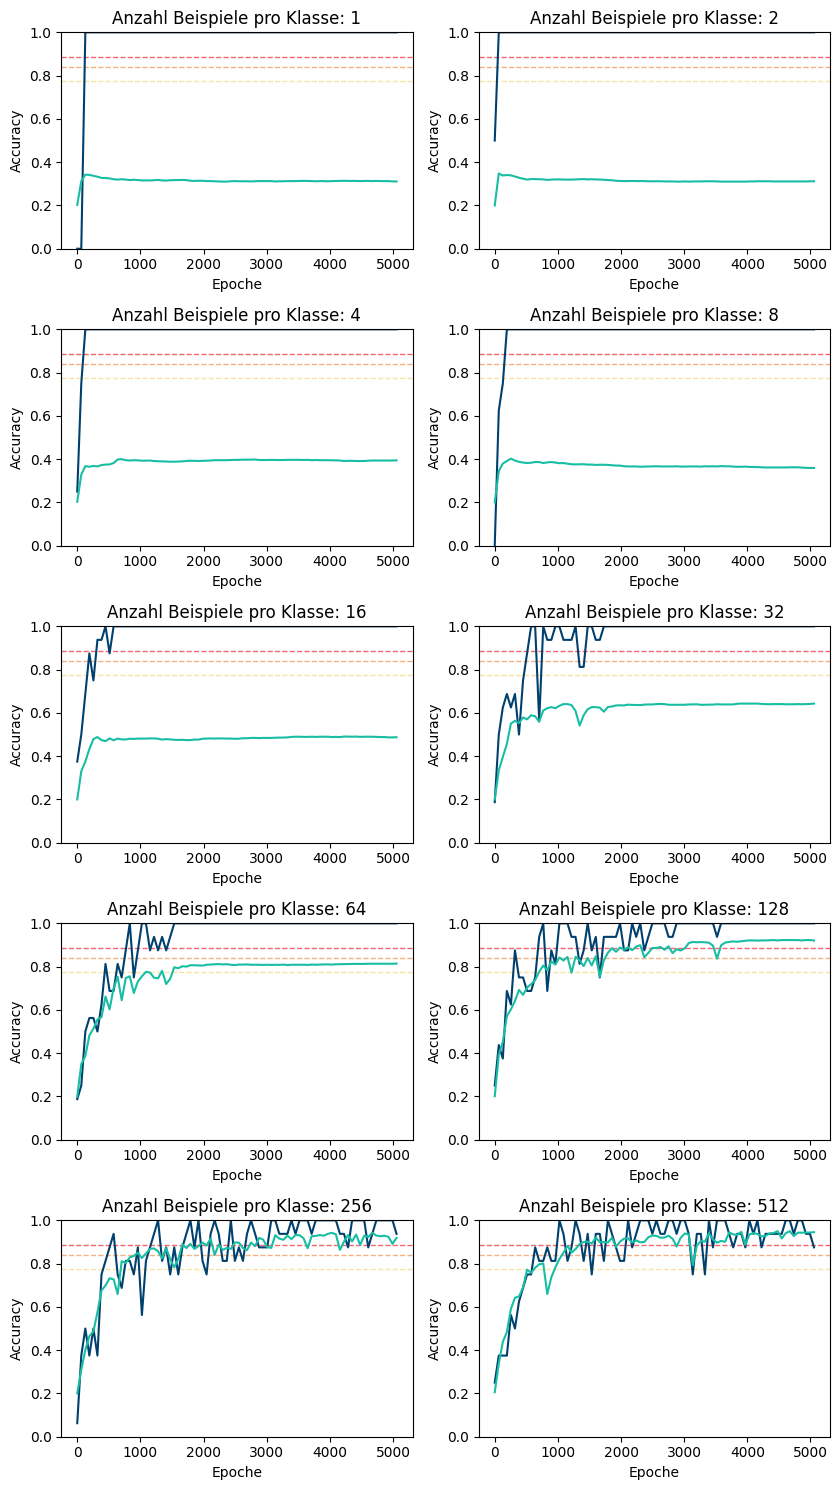



  Anzahl Beispiele pro Klasse    Beste Test-Accuracy
-----------------------------  ---------------------
                        1.000                  0.342
                        2.000                  0.348
                        4.000                  0.400
                        8.000                  0.402
                       16.000                  0.491
                       32.000                  0.643
                       64.000                  0.814
                      128.000                  0.923
                      256.000                  0.942
                      512.000                  0.950


\begin{tabular}{rr}
\hline
   Anzahl Beispiele pro Klasse &   Beste Test-Accuracy \\
\hline
                         1.000 &                 0.342 \\
                         2.000 &                 0.348 \\
                         4.000 &                 0.400 \\
                         8.000 &                 0.402 \\
                        16.000 &    

In [ ]:
num_classes = 5
class_combinations = [[3, 13], [12, 15], [19, 19], [21, 24], [24, 19]]
reference_accs = [0.773, 0.840, 0.888]

run_task(X, y, num_classes, class_combinations, reference_accs)

## Task: Classification of 10 classes

####################################################
##### Task: Classification of 10 hand-gestures. #####
####################################################

Performing data preparation steps...
Data preparation finished.

Starting training-runs...

Training with 1 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 4:38.2 (18.40/s)    
Training with 2 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 2:40.8 (31.84/s)    
Training with 4 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 1:35.8 (53.46/s)    
Training with 8 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 1:02.4 (82.05/s)    
Training with 16 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 46.5s (110.20/s)   
Training with 32 samples per class... |████████████████████████████████████████| 5120/5120 [100%] in 46.2s (110.89/s)   
Training with 64 samp

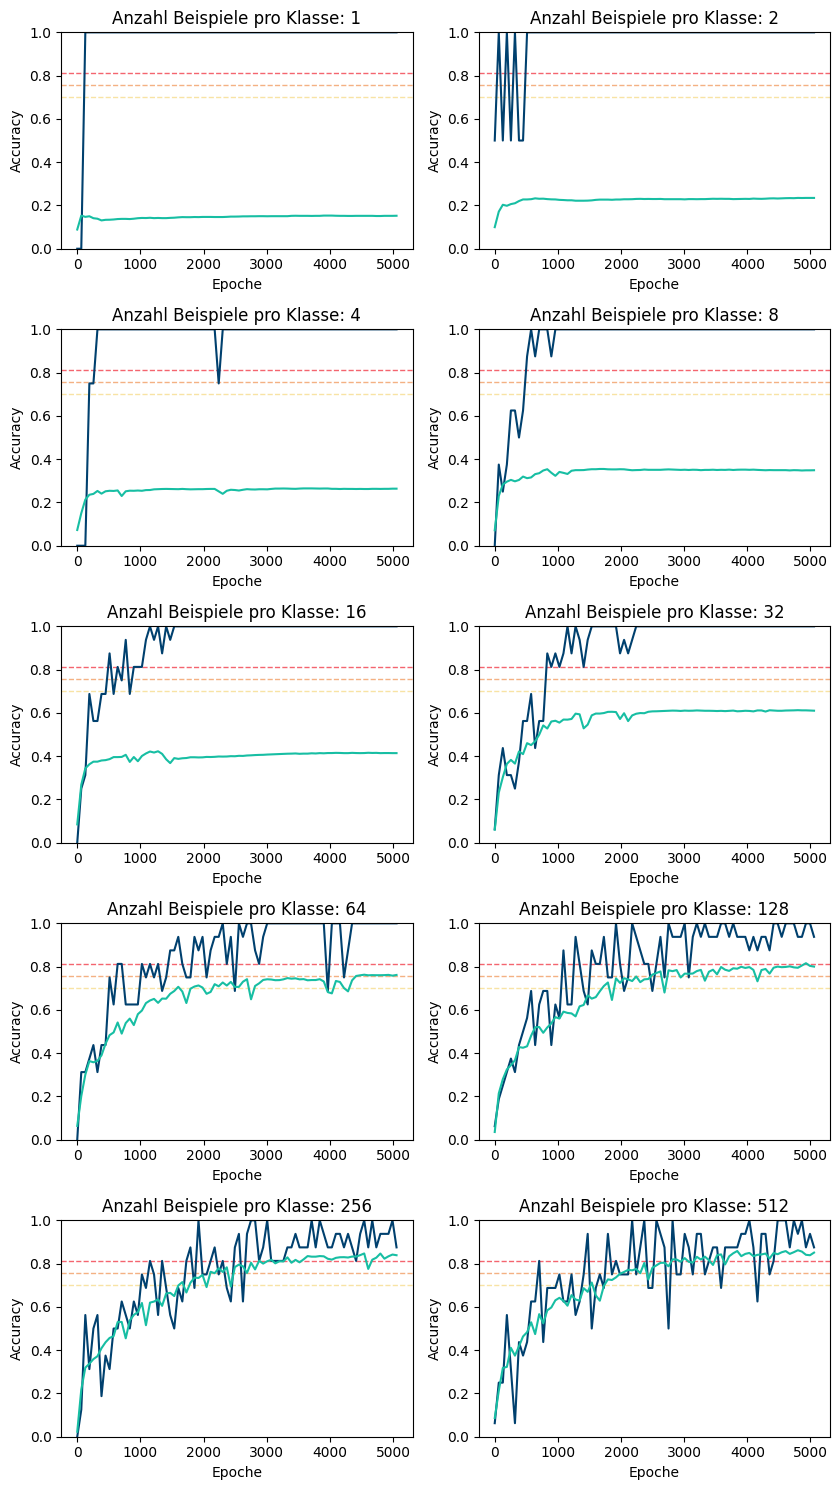



  Anzahl Beispiele pro Klasse    Beste Test-Accuracy
-----------------------------  ---------------------
                        1.000                  0.153
                        2.000                  0.235
                        4.000                  0.265
                        8.000                  0.355
                       16.000                  0.423
                       32.000                  0.613
                       64.000                  0.763
                      128.000                  0.816
                      256.000                  0.847
                      512.000                  0.862


\begin{tabular}{rr}
\hline
   Anzahl Beispiele pro Klasse &   Beste Test-Accuracy \\
\hline
                         1.000 &                 0.153 \\
                         2.000 &                 0.235 \\
                         4.000 &                 0.265 \\
                         8.000 &                 0.355 \\
                        16.000 &    

In [ ]:
num_classes = 10
class_combinations = [[0, 21], [3, 12], [12, 15], [13, 3], [19,13], [24, 21], [21, 13], [19, 24], [0, 15], [3, 24]]
reference_accs = [0.703, 0.757, 0.812]

run_task(X, y, num_classes, class_combinations, reference_accs)